In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from discretize_sepsis_actions import discretize_actions
import pickle
import os.path

%matplotlib inline  

In [2]:
path = '/Users/dilys/Desktop/Harvard_1718_Fall/CS282/cs282-f17-xuefeng-yi-david'

# For David 

### code for Jerry's cluster

In [3]:
# read the src
# data = np.genfromtxt("/Users/dilys/Desktop/Harvard_1718_Fall/CS282/Homework/HW3/P2/Sepsis_imp.csv", dtype=float, delimiter=',', skip_header=1) 
# remove intervention, but include ventilation, sedation, RRT
# interventions = np.setdiff1d(np.arange(47, 57), [51,52,54,55,56]) #[52,53,55,57]
# data = np.delete(data, interventions, axis=1)
# data = np.delete(data, [0,1,2], axis=1)

# data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

### Modification to allow classification

In [4]:
data = pd.read_csv(os.path.join(path, 'data/Sepsis_imp.csv'))
interventions = np.setdiff1d(np.arange(47, 57), [51,52,54,55,56])
features = data.columns[list(set(range(data.shape[1])) - set(range(3)) - set(interventions))]
data = data[features]
features

Index([u'gender', u'age', u'elixhauser', u're_admission', u'SOFA', u'SIRS',
       u'Weight_kg', u'GCS', u'HR', u'SysBP', u'MeanBP', u'DiaBP',
       u'Shock_Index', u'RR', u'SpO2', u'Temp_C', u'FiO2_1', u'Potassium',
       u'Sodium', u'Chloride', u'Glucose', u'BUN', u'Creatinine', u'Magnesium',
       u'Calcium', u'Ionised_Ca', u'CO2_mEqL', u'SGOT', u'SGPT', u'Total_bili',
       u'Albumin', u'Hb', u'WBC_count', u'Platelets_count', u'PTT', u'PT',
       u'INR', u'Arterial_pH', u'paO2', u'paCO2', u'Arterial_BE',
       u'Arterial_lactate', u'HCO3', u'PaO2_FiO2', u'output_total',
       u'output_4hourly', u'sedation', u'mechvent', u'rrt', u'died_in_hosp',
       u'mortality_90d'],
      dtype='object')

In [5]:
# mean and std for standardizing 
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)

In [6]:
# cluster centers for classifying states to 0 - 1999
centers = pickle.load(open(os.path.join(path,'code/state_cluster/centers.pkl'), 'rb'))
centers = pd.DataFrame(centers)
centers.columns = features

In [7]:
classify_state_params = {'features': features,
                        'centers': centers,
                        'mean': data_mean,
                        'std': data_std}
pickle.dump(classify_state_params, \
            open(os.path.join(path, 'data/classify_state/classify_state_param.pkl'), 'wb'))

In [8]:
def classify_state(new_state, params):
    
    features = params['features']
    centers = params['centers']
    data_mean = params['mean']
    data_std = params['std']
    
    # extract features for clustering
    state = new_state[features]
    # standardize states
    state_std = (state - data_mean)/data_std
    # assign to the nearest cluster
    state_discretized = np.argmin(np.sum((centers - state_std)**2, axis = 1))
    
    return state_discretized

In [9]:
# example for classifying state
params = pickle.load(open(os.path.join(path, 'data/classify_state/classify_state_param.pkl'), 'rb'))
classify_state(data.ix[1,],params)

1575

# Preparation

In [30]:
# load data
data = pd.read_csv(os.path.join(path, 'data/Sepsis_imp.csv'))
states = pickle.load(open(os.path.join(path, 'code/state_cluster/states_list.pkl'), 'rb'))

In [14]:
# Discretize action (from omer's code)
actions, \
input_4hourly__conversion_from_binned_to_continuous, \
median_dose_vaso__conversion_from_binned_to_continuous \
= discretize_actions(data['input_4hourly_tev'], data['median_dose_vaso'], bins_num = 5)


In [15]:
# extra icustyid, state, action, reward, death as dataframe
# assign intermediate reward as -1
icustayid = data['icustayid']
death = data['died_in_hosp']
rewards = np.zeros((data.shape[0])); rewards.fill(-1)
d = {'id': icustayid.astype('int'),\
     's':states.astype('int'),\
     'a': actions.astype('int'),\
     'r': rewards.astype('int'),
     'd': death.astype('int')
}
subdata = pd.DataFrame(d, columns = ['id','s','a','r','d'])
patients  = icustayid.unique()

In [16]:
# rearrange data into dictionary format
# each trajectory is an element in the dictionary
# create two final absorbing states: death or not 
# reward for death: -50; dispatched: + 50
print 'Transforming Dataframe to Dictionary'
Episodes= {}
j = 0
for i in patients:
    temp = subdata[subdata['id'] == i]
    T = len(temp)
    history = np.zeros((T, 5))
    
    s1 = temp['s'].iloc[T-1]
    a = temp['a'].iloc[T-1]
    if temp['d'].iloc[-1] == 0:
        s2 = 2000
        r = 50
    else:
        s2 = 2001
        r = -50
    history[T-1] = np.array([T-1, s1, a, s2, r])
    
    if T ==1:
        continue
    
    for t in range(T - 1 ):
        s1 = temp['s'].iloc[t]
        a = temp['a'].iloc[t]
        s2 = temp['s'].iloc[t + 1]
        r = temp['r'].iloc[t]
        
        history[t] = np.array([t, s1, a, s2, r])
        
    Episodes[j] = pd.DataFrame(history, columns = ['T','S1','A','S2','R'])
    j = j+ 1
    if j%1000 == 0:
        print '{}% finished'.format(round(100.0*j/len(patients),2))
print 'Finish transforming'
pickle.dump(Episodes, open('Episodes.pkl', 'wb'))

Transforming Dataframe to Dictionary
5.19% finished
10.38% finished
15.56% finished
20.75% finished
25.94% finished
31.13% finished
36.32% finished
41.5% finished
46.69% finished
51.88% finished
57.07% finished
62.26% finished
67.44% finished
72.63% finished
77.82% finished
83.01% finished
88.2% finished
93.39% finished
Finish transforming


# Functions for SARSA and Q_Learning

In [17]:
# Update the Q table 
def update_Q_SARSA( Q_table, state, action, reward, new_state, new_action, gamma = 0.95, alpha = 0.1):
    # FILL THIS IN 
    state = int(state); action = int(action); new_state = int(new_state); new_action = int(new_action)
    Q_table[state,action] = Q_table[state,action] + alpha * ((reward + gamma * Q_table[new_state,new_action]) - Q_table[state,action])

    return Q_table 

# Update the Q table 
def update_Q_Qlearning( Q_table, state, action, reward, new_state, new_action, gamma = 0.95, alpha = 0.1):
    # FILL THIS IN 
    state = int(state); action = int(action); new_state = int(new_state); new_action = int(new_action)
    max_action = np.argmax( Q_table[new_state , : ] )
    Q_table[state,action] = Q_table[state,action] + alpha * ((reward + gamma * Q_table[new_state,max_action]) - Q_table[state,action])

    return Q_table 


In [18]:
# Functions for geting the optimal policy
def get_Optimal_Policy(Q_table):
    optimal_policy = np.zeros(Q_table.shape)
    for i in range(len(Q_table)):
        optimal_policy[i, np.argmax(Q_table[i,])] = 1
    return optimal_policy

# SARSA and Q_Learning

In [19]:
# Episodes are in dictionary format
Episodes = pickle.load(open('Episodes.pkl', 'rb'))

In [29]:
Q_table_SARSA = np.zeros((2002, 25))
Q_table_Qlearning = np.zeros((2002, 25))

count = 0
for epi in Episodes.keys():
    count = count + 1
    if (count%1000 == 1):
        print '{}% finished'.format(round(100.0*count/len(Episodes),2))
    
    epi_data = Episodes[epi]
    for t in range(len(epi_data)):
        state = epi_data.ix[t,'S1']
        action = epi_data.ix[t, 'A']
        reward = epi_data.ix[t, 'R']
        new_state = epi_data.ix[t, 'S2']
        
        if t < len(epi_data) -1:
            new_action = epi_data.ix[t+1, 'A']
        else:
            new_action = np.random.choice(25)
        
        Q_table_SARSA = update_Q_SARSA( Q_table_SARSA, state, action, reward, new_state, new_action)
        Q_table_Qlearning = update_Q_Qlearning( Q_table_Qlearning, state, action, reward, new_state, new_action)
print '100% finished'

0.01% finished
5.29% finished
10.58% finished
15.87% finished
21.15% finished
26.44% finished
31.73% finished
37.01% finished
42.3% finished
47.59% finished
52.88% finished
58.16% finished
63.45% finished
68.74% finished
74.02% finished
79.31% finished
84.6% finished
89.89% finished
95.17% finished
100% finished


In [21]:
# get the optimal policy
optimal_policy_SARSA = get_Optimal_Policy(Q_table_SARSA)
optimal_policy_Qlearning = get_Optimal_Policy(Q_table_Qlearning)

In [23]:
Q_table = {'SARSA':Q_table_SARSA, 
          'Q_Learning':Q_table_Qlearning},
pickle.dump(Q_table, open('Q_table.pkl', 'wb'))
Q_table = pickle.load(open('Q_table.pkl', 'rb'))

# Evaluation

In [31]:
vaso = np.array(list(median_dose_vaso__conversion_from_binned_to_continuous) * 5)
fluid = np.repeat(input_4hourly__conversion_from_binned_to_continuous, 5)

def Compute_Deviation(policy):
    policy_vaso = np.sum(policy*vaso, axis = 1)[states.astype('int')]
    policy_fluid = np.sum(policy*fluid, axis = 1)[states.astype('int')]
    temp = {'icustayid':icustayid,
        'death': death,
        'vaso': data['median_dose_vaso'].values,
        'fluid': data['input_4hourly_tev'].values,
        'action': actions,
        'policy_vaso': policy_vaso,
        'policy_fluid': policy_fluid,
        'vaso_dev': policy_vaso - data['median_dose_vaso'].values,
        'fluid_dev': policy_fluid - data['input_4hourly_tev'].values    
        }
    temp = pd.DataFrame(temp, columns = ['icustayid', 'death', 'vaso', \
                                     'fluid', 'action', 'policy_vaso',\
                                    'policy_fluid', 'vaso_dev', 'fluid_dev'])
    vaso_dev_mean = temp.groupby(by="icustayid")['vaso_dev'].mean().values
    fluid_dev_mean = temp.groupby(by="icustayid")['fluid_dev'].mean().values
    outcome = temp.groupby(by="icustayid")['death'].mean().values
    result = {'vaso_dev':temp['vaso_dev'],
              'vaso_dev_mean':vaso_dev_mean, 
              'fluid_dev':temp['fluid_dev'], 
              'fluid_dev_mean': fluid_dev_mean
    }
    
    return result

In [33]:
def get_bins(devs, death, var):
    d_bins = {'vaso': np.linspace(-5,3,59),
              'fluid':range(-10000,1000,200)  
    }
    
    bins = d_bins[var]
    temp_dead = devs[death == 1]
    temp_surv = devs[death == 0]
    
    a, _ = np.histogram(temp_dead, bins)
    b, _ = np.histogram(temp_surv, bins)
    
    m = a*1.0/(a+b) 
    midpoint = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    
    result = {'mortality': m,
              'dev': midpoint   
    }
  

    return result

In [32]:
SARSA = Compute_Deviation(optimal_policy_SARSA)
Q_Learning = Compute_Deviation(optimal_policy_Qlearning)

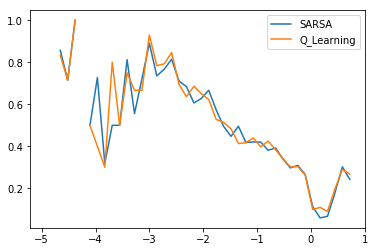

In [34]:
Draw_SARSA = get_bins(SARSA['vaso_dev'], death, 'vaso')
Draw_Qlearning = get_bins(Q_Learning['vaso_dev'], death, 'vaso')
plt.plot(Draw_SARSA['dev'], Draw_SARSA['mortality'], label = 'SARSA')
plt.plot(Draw_Qlearning['dev'], Draw_Qlearning['mortality'], label = 'Q_Learning')
plt.legend()

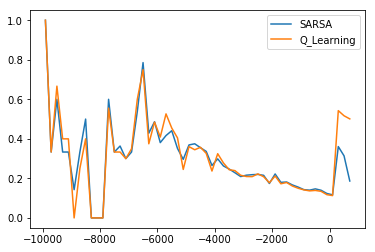

In [35]:
Draw_SARSA = get_bins(SARSA['fluid_dev'], death, 'fluid')
Draw_Qlearning = get_bins(Q_Learning['fluid_dev'], death, 'fluid')
plt.plot(Draw_SARSA['dev'], Draw_SARSA['mortality'], label = 'SARSA')
plt.plot(Draw_Qlearning['dev'], Draw_Qlearning['mortality'], label = 'Q_Learning')
plt.legend()

# Bootstrap Confidence Interval

In [36]:
# Take in episodes in dictionary form
# learn Q_table with SARSA and Q_Learning
def get_Q_table(Episodes):
    # Episodes is a dictionary
    # element in Episode is a dataframe, with t, S1, A, R, S2
    Q_table_SARSA = np.zeros((2002, 25))
    Q_table_Qlearning = np.zeros((2002, 25))

    for epi in Episodes.keys():
        data = Episodes[epi]
        for t in range(len(data)):
            state = data.ix[t,'S1']
            action = data.ix[t, 'A']
            reward = data.ix[t, 'R']
            new_state = data.ix[t, 'S2']

            if t < len(data) -1:
                new_action = data.ix[t+1, 'A']
            else:
                new_action = np.random.choice(25)

            Q_table_SARSA = update_Q_SARSA( Q_table_SARSA, state, action, reward, new_state, new_action)
            Q_table_Qlearning = update_Q_Qlearning( Q_table_Qlearning, state, action, reward, new_state, new_action)
    result = {'SARSA': Q_table_SARSA,
             'Q_Learning': Q_table_Qlearning}
    return(result)

In [ ]:
B_times = 10
Bootstrap_Q_table = {'SARSA': np.zeros((2002,25,B_times)),
                    'Q_Learning': np.zeros((2002,25,B_times))}

for i in range(B_times):
    print i
    # choose bootstrap samples
    to_choose = np.random.choice(Episodes.keys(), size = int(0.8*len(Episodes)), replace=False)
    newdata = {x:Episodes[x] for x in to_choose}
    
    tables = get_Q_table(newdata)
    Bootstrap_Q_table['SARSA'][:,:,i] = tables['SARSA']
    Bootstrap_Q_table['Q_Learning'][:,:,i] = tables['Q_Learning']
    

0
1


In [ ]:
np.std(Bootstrap_Q_table['SARSA'], axis = (2))
np.mean(Bootstrap_Q_table['SARSA'], axis = (2))